総フレーム数:  449.0
fps:  29.97002997002997
動画の長さ:  14.981633333333333 [sec]


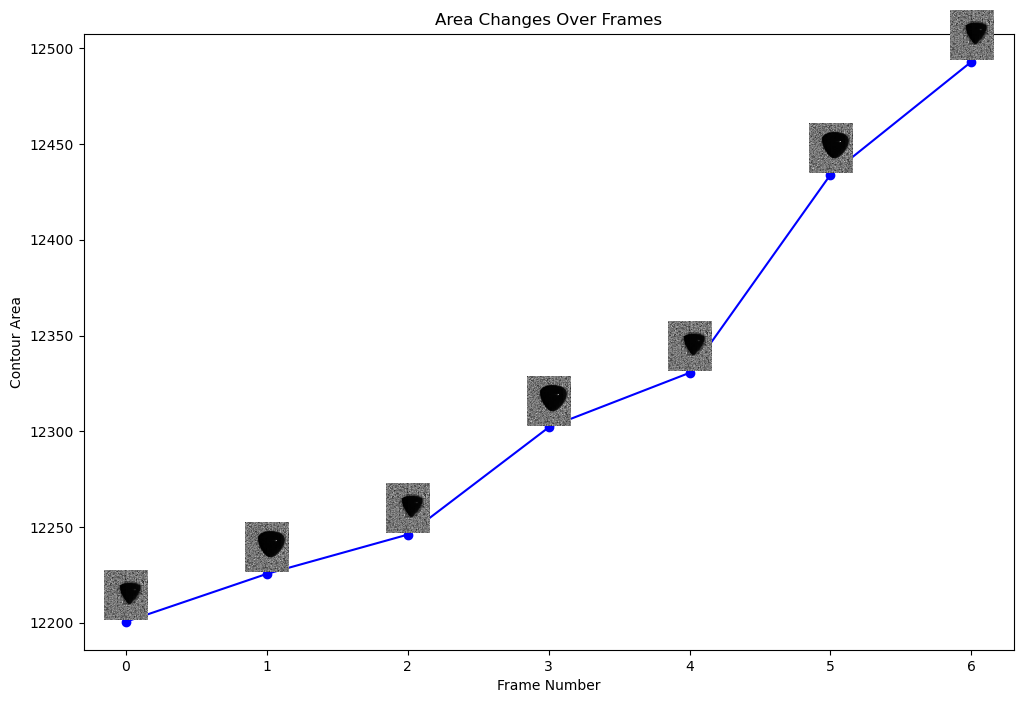

In [1]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
# ビデオデータの読み込み
filename = "C:\\Users\\flow\\Desktop\\bubbledate\\tetrahedronGray.mp4"
base_path= "C:\\Users\\flow\\Desktop\\bubble_rasing_result\\"
# 動画ファイルのベース名を取得
video_base_name = os.path.splitext(os.path.basename(filename))[0]

# 動画ごとのディレクトリを作成
video_directory = os.path.join(base_path, video_base_name)
os.makedirs(video_directory, exist_ok=True)  # 既に存在している場合は作成しない
# 新しいフォルダのベース名を指定
folder_names = ["th_image", "th_contours", "th_result", "th_threshold", "th_graph"]

# 新しいフォルダを作成
for folder_name in folder_names:
    new_folder_path = os.path.join(video_directory, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)

# 動画の読み込み
cap = cv2.VideoCapture(filename=filename)
#動画ファイルの情報を取得する
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
hight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print("総フレーム数: ", total_frame)
print("fps: ", fps)
print("動画の長さ: ", total_frame/fps, "[sec]")

frame_count = 0  # フレームのカウントを初期化

# グラフ用のデータ格納リスト
area_data = []
perimeter_data = []
moment_data = []

while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        # フレーム番号が30の倍数のときだけ処理を行う
        if frame_count % 30 == 0:
            num = frame_count // 30  # 画像ファイルの番号を計算
        # 各処理のpathをvideo_directoryに基づいて生成
            path = os.path.join(video_directory, "th_image\\")
            contours_path = os.path.join(video_directory, "th_contours\\")
            result_path = os.path.join(video_directory, "th_result\\")
            threshold_path = os.path.join(video_directory, "th_threshold\\")
            
            # 画像を保存
            image_path = path + "picture{:0=3}.bmp".format(num)
            cv2.imwrite(image_path, frame)

            # 画像を読み込み
            color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if color_image is None:
                print(f"Error: Failed to load image from {image_path}")
                sys.exit(1)  # スクリプトを終了する

            # グレースケールに変換
            gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
            #平滑化
            blurred_image = cv2.bilateralFilter(gray_image, 5, 10, 10)
            # 2値化
            ret, binary = cv2.threshold(blurred_image ,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            # 2値化画像を保存
            thresholds_path = threshold_path + " threshold_picture{:0=3}.bmp".format(num)
            cv2.imwrite(thresholds_path, binary)
            
            
            # 輪郭検出（フィルタリングなし）
            raw_contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

            # 画像コピー（フィルタリングなし）
            raw_img_with_contours = frame.copy()

            # 全ての輪郭を描画（フィルタリングなし）
            cv2.drawContours(raw_img_with_contours, raw_contours, -1, (0, 255, 0), 2)

            # 描画画像を保存（フィルタリングなし）
            raw_contours_image_path = os.path.join(contours_path, "raw_contours_picture{:0=3}.bmp".format(num))
            cv2.imwrite(raw_contours_image_path, raw_img_with_contours)
            
            
            # 輪郭検出
            contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            # 動画ごとの条件セットを定義
            conditions = {
                "min_contour_area": 10000,  # この面積以下の輪郭は無視する
                "max_contour_area": 20000,
            }

            # フィルタリングされた輪郭を格納するリスト
            filtered_contours = []

            # 各輪郭に対して条件をチェックし、データを収集
            for idx, contour in enumerate(contours):
                contour_area = cv2.contourArea(contour)

                # 条件をチェック
                if (
                    ("min_contour_area" not in conditions or contour_area >= conditions["min_contour_area"]) and
                    ("max_contour_area" not in conditions or contour_area <= conditions["max_contour_area"])
                ):
                    filtered_contours.append(contour)
                    
                    # 面積データを追加
                    area_data.append(contour_area)
                    # 周囲長データを追加
                    perimeter_data.append(cv2.arcLength(contour, True))
                    
                    # モーメントデータを追加
                    M = cv2.moments(contour)
                    cx = int(M['m10'] / M['m00']) if M["m00"] != 0 else 0
                    cy = int(M['m01'] / M['m00']) if M["m00"] != 0 else 0
                    moment_data.append((cx, cy))

            # 条件を満たす輪郭が1つ以上存在するかをチェック
            if len(filtered_contours) > 0:


                # 輪郭検出結果を保存（グリーン色で描画された画像）
                result_image = color_image.copy()
                cv2.drawContours(result_image, filtered_contours, -1, (0, 255, 0), 2)
                
                # 描画画像に面積を描画して保存
                for contour, moment in zip(filtered_contours, moment_data):
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        cx, cy = moment
                        area = cv2.contourArea(contour)
                        
                        # 面積を描画
                        cv2.putText(result_image, f"Area: {area}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                
                result_image_path = os.path.join(result_path, "result_picture{:0=3}.bmp".format(num))
                cv2.imwrite(result_image_path, result_image)
            
            
            
    else:
        break

    frame_count += 1

cap.release()  # カメラリソースの解放
cv2.destroyAllWindows()  # ウィンドウの破棄

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def draw_image(ax, image_path, xy, zoom=0.15, crop_box=None):
    image = plt.imread(image_path)
    
    if crop_box is not None:
        x1, y1, x2, y2 = crop_box
        image = image[y1:y2, x1:x2]
    
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, pad=0)
    ax.add_artist(ab)
            
#フレームごとの面積データをプロット
# フレームごとの面積データをプロット（大きなサイズのグラフ）
fig, ax = plt.subplots(figsize=(12, 8))  # 幅: 10インチ、高さ: 6インチ


# グラフのタイトルとラベルを設定
plt.title("Area Changes Over Frames")
plt.xlabel("Frame Number")
plt.ylabel("Contour Area")

# グラフをプロット
ax.plot(range(len(area_data)), area_data, marker='o', linestyle='-', color='b')

# 各点に対応するフレーム画像を描画
for idx, (x, y) in enumerate(zip(range(len(area_data)), area_data)):
    image_path = os.path.join(video_directory, "th_image", f"picture{idx:03}.bmp")
    #トリミングする範囲を指定（左上隅と右下隅の座標）
    crop_box = (200, 210, 410, 450)  # ここに適切な座標を設定
    # 画像を点の少し上に表示（例えば、10ピクセル上にずらす）
    offset = 14 # ずらす距離
    draw_image(ax, image_path, (x, y + offset), crop_box=crop_box)
    
# グラフを保存
graph_save_path = os.path.join(video_directory, "th_graph", "area_graph_with_images.png")
plt.savefig(graph_save_path)

# グラフを表示
plt.show()